**Datasets and Dataloaders**

---

*Datasets from PyTorch*

torch.Size([60000, 28, 28])
torch.Size([60000])
<class 'torch.Tensor'> torch.Size([28, 28]) tensor(218, dtype=torch.uint8)
<class 'torch.Tensor'> torch.Size([])


Text(0.5, 1.0, 'tensor(9)')

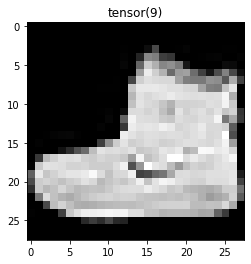

In [3]:
# There are PyTorch datasets for vision, text and audio
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt

# Create a transform to be applied to each sample
#   .ToTensor() is critical; if not, dataloader will give error
transform1 = transforms.Compose([
    transforms.ToTensor(),  # converts PIL image or numpy array (HxWxC) into a 
                            #   torch.FloatTensor (CxHxW), scales it to [0,1] 
    transforms.Normalize(mean=[0.5],std=[0.5]) # for 1 channel
                            #   [0.5,0.5,0.5] for 3 channels
                            # Conversion from RGB to gray could also be useful
                            # Transforms can also be added to the dataloader
    ])

# Download the dataset and set the transform to be applied for each sample
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = transform1
    )

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = transform1
    )

print(train_data.data.shape) 
print(train_data.targets.shape)

# Check out a sample
sample_id = 0
image = train_data.data[sample_id]
label = train_data.targets[sample_id]

print(type(image),image.shape, image[20,20]) 
print(type(label),label.shape)

plt.imshow(image, cmap="gray") # .squeeze() if img.shape is (1,28,28)
plt.title(label)


*Dataloader*

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([1, 28, 28])


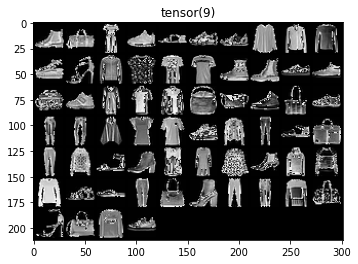

In [30]:
from torch.utils.data import DataLoader #creates an iterable around a dataset

batch_size = 64

train_dataloader = DataLoader(train_data,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size,shuffle=False)

# Working with a dataloader
for X,y in train_dataloader:
  print(X.shape) #batchsize, number of channels, height, width
  print(y.shape) #batchsize
  break # one run of the dataloader

sample_id = 0
image = X[sample_id,:,:,:]
label = y[sample_id]

print(image.shape) # torch.Size([1, 28, 28])

plt.imshow(image.squeeze(), cmap="gray") # we squeeze because shape is (1,28,28)
plt.title(label)

# visualize the batch of the dataset
import torchvision
# X is of size (b,c,h,w)
grid = torchvision.utils.make_grid(X,nrow=10) # grid is a tensor of size (c,h,w)
                                              # nrow: number of imgs in each row
transform_tensor_to_PIL = torchvision.transforms.ToPILImage() 
grid_img = transform_tensor_to_PIL(grid)     # (h,w,c)
plt.imshow(grid_img, cmap="gray")


*Datasets from numpy arrays*

In [43]:
# Let's download a dataset from sklearn
from sklearn.datasets import load_digits
digits = load_digits()

#print(digits.images.shape)  # (1797, 8, 8)
#print(type(digits.images))  # <class 'numpy.ndarray'>

# Let's do train - test split
X = digits.images
y = digits.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    shuffle=True)

print(X_train.shape, type(X_train))
print(y_train.shape, type(y_train))

# First, transform numpy to tensor
# X_train is of size (batch,h,w). Convert it to (b,c,h,w)
X_train = torch.tensor(X_train).unsqueeze(1) # unsqueeze for dimensional pos. 1
X_test = torch.tensor(X_test).unsqueeze(1)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


print(X_train.shape, type(X_train))
print(y_train.shape, type(y_train))


(1437, 8, 8) <class 'numpy.ndarray'>
(1437,) <class 'numpy.ndarray'>
torch.Size([1437, 1, 8, 8]) <class 'torch.Tensor'>
torch.Size([1437]) <class 'torch.Tensor'>


*Create a custom dataset from tensors*

torch.Size([128, 1, 8, 8])
torch.Size([128])
torch.Size([128, 1, 8, 8])
torch.Size([128])


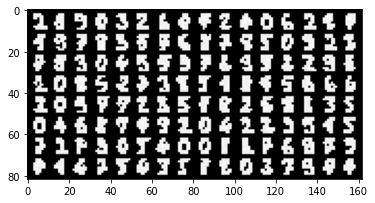

In [45]:
# We do this by using TensorDataset
from torch.utils.data import TensorDataset

# Tensors to dataset
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

# Create the dataloaders
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

# Working with a dataloader
for X,y in train_dataloader:
  print(X.shape) #batchsize, number of channels, height, width
  print(y.shape) #batchsize
  break # one run of the dataloader

# Alternatively, ...
X, y = next(iter(train_dataloader))
print(X.shape)
print(y.shape)

# Visualize
grid = torchvision.utils.make_grid(X,nrow=16) # grid is a tensor of size (c,h,w)
                                              # nrow: number of imgs in each row
transform_tensor_to_PIL = transforms.ToPILImage() 
grid_img = transform_tensor_to_PIL(grid)      # (h,w,c)
plt.imshow(grid_img)


*Create a custom dataset from image files*

In [ ]:
# We do this by writing a Dataset class 
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import transforms
from skimage import io

# For this cell to run, ...
# We need a folder with images
# We need a csv or txt annotation file with image filenames and labels, e.g.:
#   img1.jpg, 0
#   img2.jpg, 0
#   img3.jpg, 1
#   ...

class CustomImageDataset(Dataset):
  def __init__(self,annotation_file,img_dir,transform=None,target_transform=None):
    self.images_labels_df = pd.read_csv(annotation_file, 
                                        header=None, 
                                        names=["Image name", "Label"])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
  
  def __len__(self):
    return len(self.images_labels_df)
  
  def __getitem__(self,idx):
    #iloc indexed location, 0 is filename, 1 is target label
    img_path = os.path.join(self.img_dir, self.images_labels_df.iloc[idx,0]) 
    image = read_image(img_path) # this produces tensor of size c,h,w
    #image = io.imread(img_path) # if used, transform w/ transforms.ToTensor()

    # do not forget to convert the label to torch tensor as well
    label = torch.tensor((self.images_labels_df.iloc[idx,1])) 
    
    if self.transform:
      image = self.transform(image)
    
    if self.target_transform:
      label = self.target_transform(label)

    return image, label


# Let's now check it out

# Directory and annotation file
img_dir = './sample_data/images/'
annotation_file = './sample_data/labels.txt'

# Create the custom dataset
custom_dataset = CustomImageDataset(annotation_file=annotation_file, 
                                    img_dir=img_dir, 
                                    transform=None)  

# Create the dataloader
dataloader = DataLoader(dataset=custom_dataset,batch_size=1)

# Check it out
X, y = next(iter(dataloader))
print(X.shape)
print(y.shape)




torch.Size([1, 3, 2048, 2048])
torch.Size([1])
